In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("cleand.csv")

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(df['Tags'])

In [4]:
multilabel_y.shape,multilabel_y[0]

((4206307, 42048), <1x42048 sparse matrix of type '<class 'numpy.int64'>'
 	with 2 stored elements in Compressed Sparse Row format>)

so there are 42048 tags

In [5]:
t = multilabel_y.sum(axis=0).tolist()[0]
sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
def tags_to_choose(n):
   
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [6]:
import numpy as np
questions_explained_fn(1)

3874802

In [7]:
#multilabel_y.sum(axis=0).tolist()[0]

In [8]:
t[4337],max(t)

(331505, 331505)

In [9]:
multilabel_yn = tags_to_choose(10000)
x= multilabel_yn.sum(axis=1)


In [10]:
(np.count_nonzero(x==0))

17292

In [11]:
import numpy as np
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=df.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

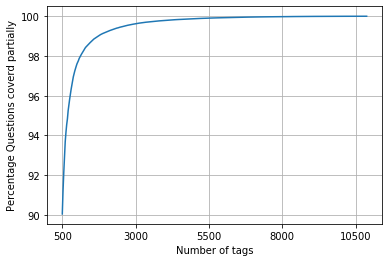

with  5500 tags we are covering  99.026 % of questions


In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Percentage Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

500 tags are covering 90%

# splitting data

In [14]:
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")
df1=df[:500000]
total_size=df1.shape[0]
train_size=int(0.80*total_size)

x_train=df1[:train_size]
x_test=df1[train_size:]

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

number of questions that are not covered : 418393 out of  4206307
Number of tags in sample : 42048
number of tags taken : 500 ( 1.189117199391172 %)


In [15]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((400000, 3), (100000, 3), (400000, 500), (100000, 500))

# Tfidf for questions 

In [16]:
import datetime as dt
start = dt.datetime.now()
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['Question'])
x_test_multilabel = vectorizer.transform(x_test['Question'])
print("Time taken to run this cell :", dt.datetime.now() - start)

Time taken to run this cell : 0:02:28.980813


In [17]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 96933) Y : (400000, 500)
Dimensions of test data X: (100000, 96933) Y: (100000, 500)


In [18]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [19]:
start = dt.datetime.now()
classifier = OneVsRestClassifier(LogisticRegression(penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
print("Time taken to run this cell :", dt.datetime.now() - start)

C:\Users\saireddyavs\Anaconda3\envs\gpuu\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Time taken to run this cell : 1:00:15.546768


In [21]:
start=dt.datetime.now()
predictions = classifier.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", dt.datetime.now() - start)

Accuracy : 0.23986
Hamming loss  0.00280388
Micro-average quality numbers
Precision: 0.6893, Recall: 0.3567, F1-measure: 0.4701
Macro-average quality numbers
Precision: 0.5283, Recall: 0.2823, F1-measure: 0.3535
              precision    recall  f1-score   support

           0       0.64      0.36      0.46      8189
           1       0.78      0.40      0.53      6529
           2       0.83      0.53      0.65      5086
           3       0.77      0.44      0.56      6430
           4       0.94      0.77      0.84      5519
           5       0.86      0.60      0.71      4533
           6       0.71      0.43      0.54      3231
           7       0.87      0.59      0.71      2548
           8       0.67      0.39      0.49      3009
           9       0.79      0.43      0.56      2879
          10       0.86      0.62      0.72      2151
          11       0.57      0.19      0.28      3051
          12       0.51      0.14      0.22      3000
          13       0.58      0.

In [22]:
import joblib

In [23]:
joblib.dump(classifier, 'logistic_regression.pkl')

['logistic_regression.pkl']